In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit import Aer
from qiskit.opflow import X, Z, I, MatrixEvolution
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit import Parameter
from qiskit import transpile
from scipy import linalg
from scipy.special import binom
import matplotlib.pyplot as plt
from qutip import *
import itertools as it
import copy
import stomp_functions as stf
from qiskit.quantum_info import random_clifford
import time
from qiskit.providers.fake_provider import FakeBelem

/tmp/ipykernel_3750168/3572349411.py:4: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import X, Z, I, MatrixEvolution


In [2]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
backend = FakeBelem()
num_shots = 1*8192

# Set up parameters for unitary
beta = 0.2
num_steps = 10
betas, dt = np.linspace(0, beta, num_steps, retstep=True)

## N=2

In [4]:
N = 2
g = 2
j = 1

In [5]:
z_ops, x_ops = stf.construct_op_lists(N)

In [6]:
# Construct the Hamiltonian
# Loop over sites to construct parts of H
H_qis = 0
for n in range(N-1):
    H_qis += -j * z_ops[n] @ z_ops[n+1]
    for m in range(N):
        H_qis += -j * g * x_ops[n]

# Get eigenenergies from H
E_qis, V_qis = linalg.eigh(H_qis.to_matrix())

In [7]:
# Define initial wavefunction
init_wf = np.array([1, 0, 0, 0])

# Create circuit registers
qr = QuantumRegister(N)
qar = AncillaRegister(1)
cr = ClassicalRegister(1)
cliff = random_clifford(N, seed=5)
init_wf = cliff.to_matrix() @ init_wf

In [8]:
# Get circuits for real and imaginary Hadamard estimation with no observable
he_circs_re = stf.had_est_barr(qr, qar, cr, H_qis, None, num_steps, 
                                      dt, cliff)
he_circs_im = stf.im_had_est_barr(qr, qar, cr, H_qis, None, num_steps, 
                                      dt, cliff)

In [9]:
# Get the overlap lists for the circuits with no observables
ovlps_r = stf.get_ovlps(he_circs_re, backend, num_shots)
ovlps_i = stf.get_ovlps(he_circs_im, backend, num_shots)
ovlps = ovlps_r + 1j * ovlps_i

In [10]:
# Now that we have the overlaps, we want to calculate the expectation value of H at each step
pauli_H = stf.pauli_string_decomp(H_qis, 2)

In [11]:
# Now perform hadmard estimation on each string
H_circs_r = {}
H_circs_i = {}
for key in pauli_H:
    if abs(pauli_H[key]) != 0:
        H_circs_r[key] = stf.had_est_barr(qr, qar, cr, H_qis, Pauli(key), num_steps, dt,
                                                 cliff)
        
        H_circs_i[key] = stf.im_had_est_barr(qr, qar, cr, H_qis, Pauli(key), num_steps,
                                                                   dt, cliff)

In [12]:
# Get real part of H expectations
H_ovlps_re = 0
for key in H_circs_r:
    temp = stf.get_ovlps(H_circs_r[key], backend, num_shots)
    H_ovlps_re += pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [13]:
# Get imag part of H expectations
H_ovlps_im = 0
for key in H_circs_i:
    temp = stf.get_ovlps(H_circs_i[key], backend, num_shots)
    H_ovlps_im += 1j * pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [14]:
# Get total H expectation
total_H_ovlp = H_ovlps_re + H_ovlps_im

In [15]:
# Classical calculation
class_ovlp, class_E_ovlp = stf.classical_calc(np.array(init_wf), H_qis.to_matrix(),
                                              H_qis.to_matrix(), num_steps, dt)

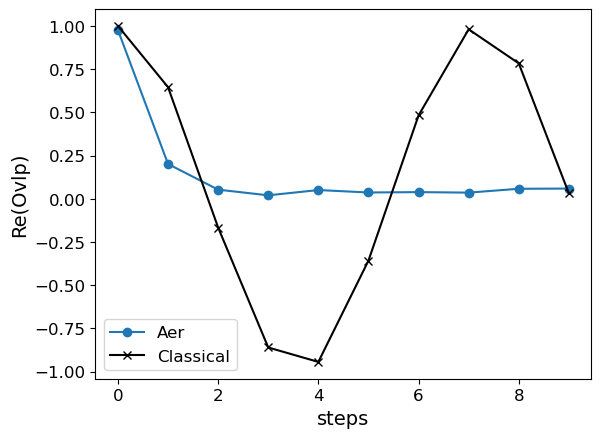

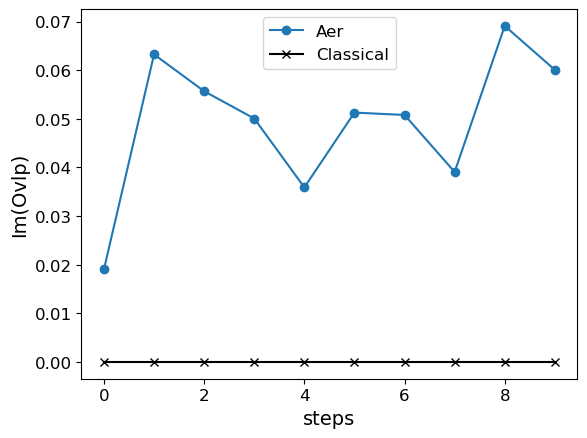

In [16]:
plt.figure(1)
plt.plot(ovlps.real, 'o-', label='Aer')
plt.plot(class_ovlp.real, 'kx-', label='Classical')
plt.ylabel("Re(Ovlp)")
plt.xlabel("steps")
plt.legend(numpoints=1)

plt.figure(2)
plt.plot(ovlps.imag, 'o-', label='Aer')
plt.plot(class_ovlp.imag, 'kx-', label='Classical')
plt.ylabel("Im(Ovlp)")
plt.xlabel("steps")
plt.legend(numpoints=1)

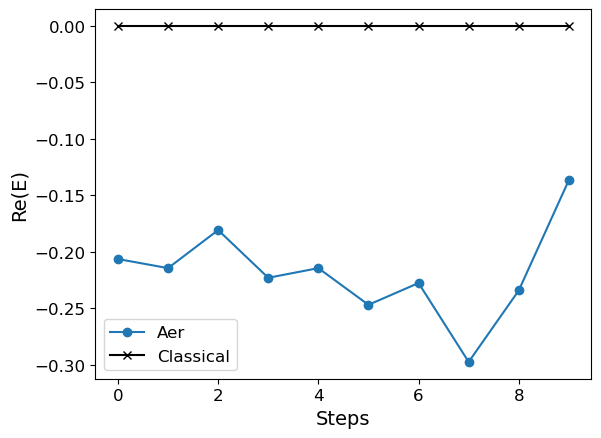

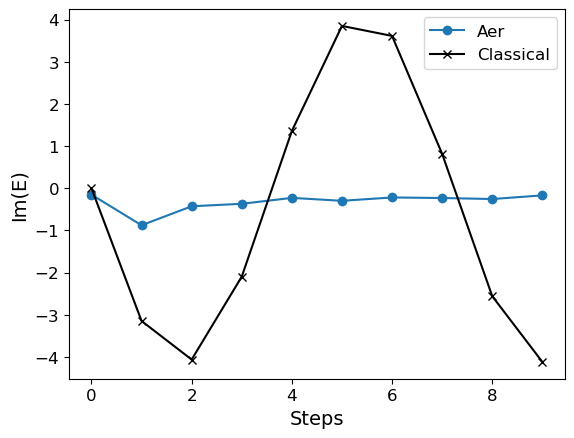

In [17]:
plt.figure(1)
plt.plot(total_H_ovlp.real, 'o-', label='Aer')
plt.plot(class_E_ovlp.real, 'kx-', label='Classical')
plt.xlabel("Steps")
plt.ylabel("Re(E)")
plt.legend(numpoints=1)

plt.figure(2)
plt.plot(total_H_ovlp.imag, 'o-', label='Aer')
plt.plot(class_E_ovlp.imag, 'kx-', label='Classical')
plt.xlabel("Steps")
plt.ylabel("Im(E)")
plt.legend(numpoints=1)

/home/jacob/anaconda3/envs/EnergyGaps/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Classical - N=2')

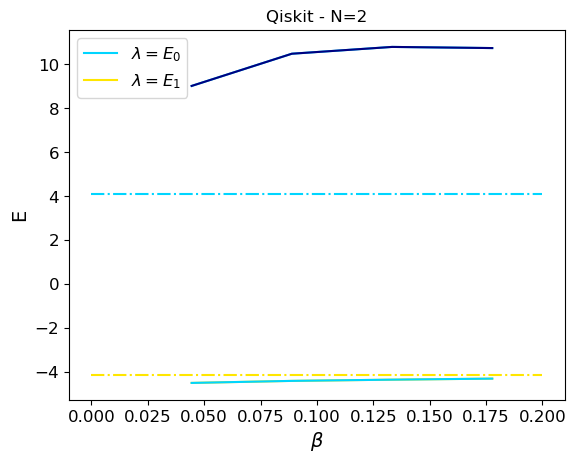

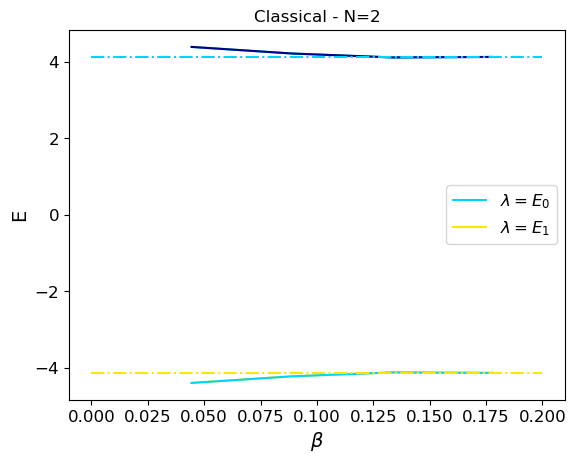

In [18]:
# Create colormap
colors = plt.cm.jet(np.linspace(0, 1, len(E_qis[::2])+2))
plt.figure(1)
l = 0
for e in E_qis[::2]:
    e = -e
    if l == 0 or l == len(E_qis[::2]) - 1:
        plt.plot(betas[2::2], stf.alt_partition_calc(ovlps, total_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l + 1],
                label='$\\lambda = E_' + str(l) + '$')
    plt.plot(betas[2::2], stf.alt_partition_calc(ovlps, total_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l])
    
    plt.plot(betas, e*np.ones(len(betas)), '-.', color=colors[l+1])
    l += 1
plt.xlabel("$\\beta$")
plt.ylabel("E")
plt.legend()
plt.title("Qiskit - N="+str(N))

plt.figure(2)
l = 0
for e in E_qis[::2]:
    e = -e
    if l == 0 or l == len(E_qis[::2]) - 1:
        plt.plot(betas[2::2], stf.alt_partition_calc(class_ovlp, class_E_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l + 1],
                label='$\\lambda = E_' + str(l) + '$')
    plt.plot(betas[2::2], stf.alt_partition_calc(class_ovlp, class_E_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l])
    
    plt.plot(betas, e*np.ones(len(betas)), '-.', color=colors[l+1])
    l += 1
plt.xlabel("$\\beta$")
plt.ylabel("E")
plt.legend()
plt.title("Classical - N="+str(N))

In [19]:
trans_re = transpile(he_circs_re, backend)
trans_im = transpile(he_circs_im, backend)
re_depths = [_.depth() for _ in trans_re]
im_depths = [_.depth() for _ in trans_re]

In [20]:
re_depths[0], re_depths[1], re_depths[2]

(9, 193, 371)

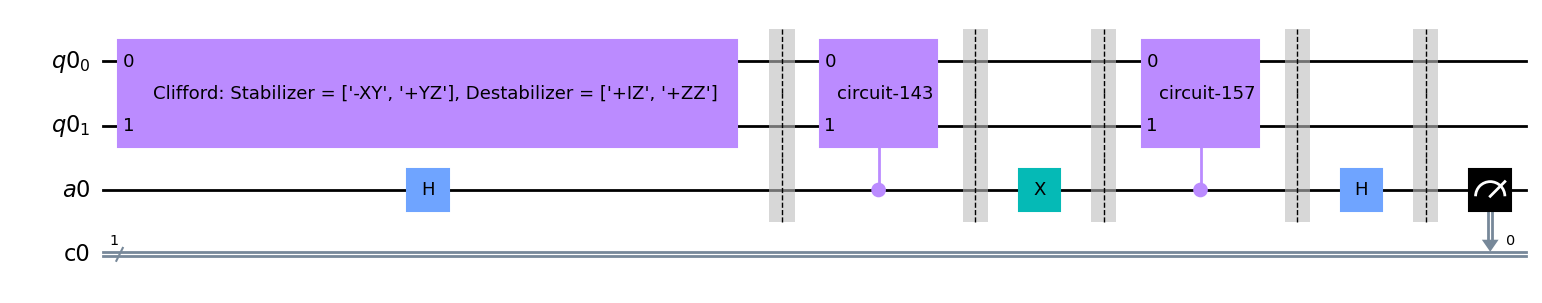

In [24]:
he_circs_re[1].draw('mpl')

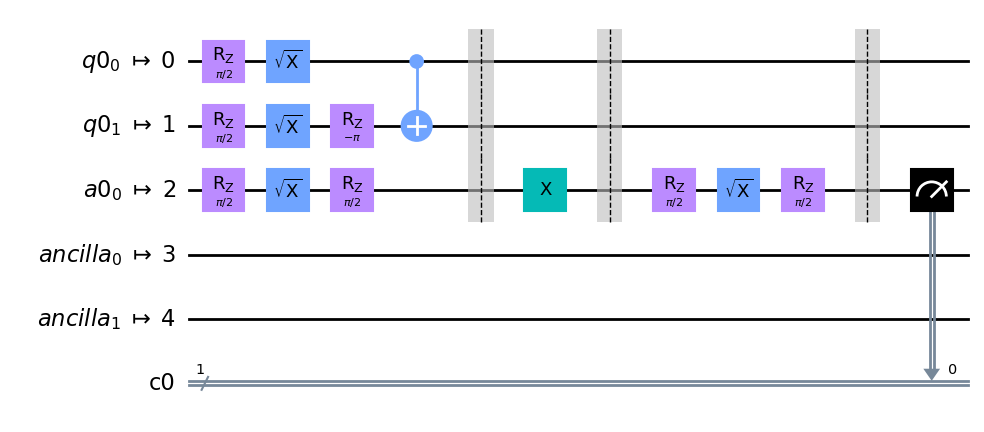

In [23]:
trans_re[0].draw('mpl')

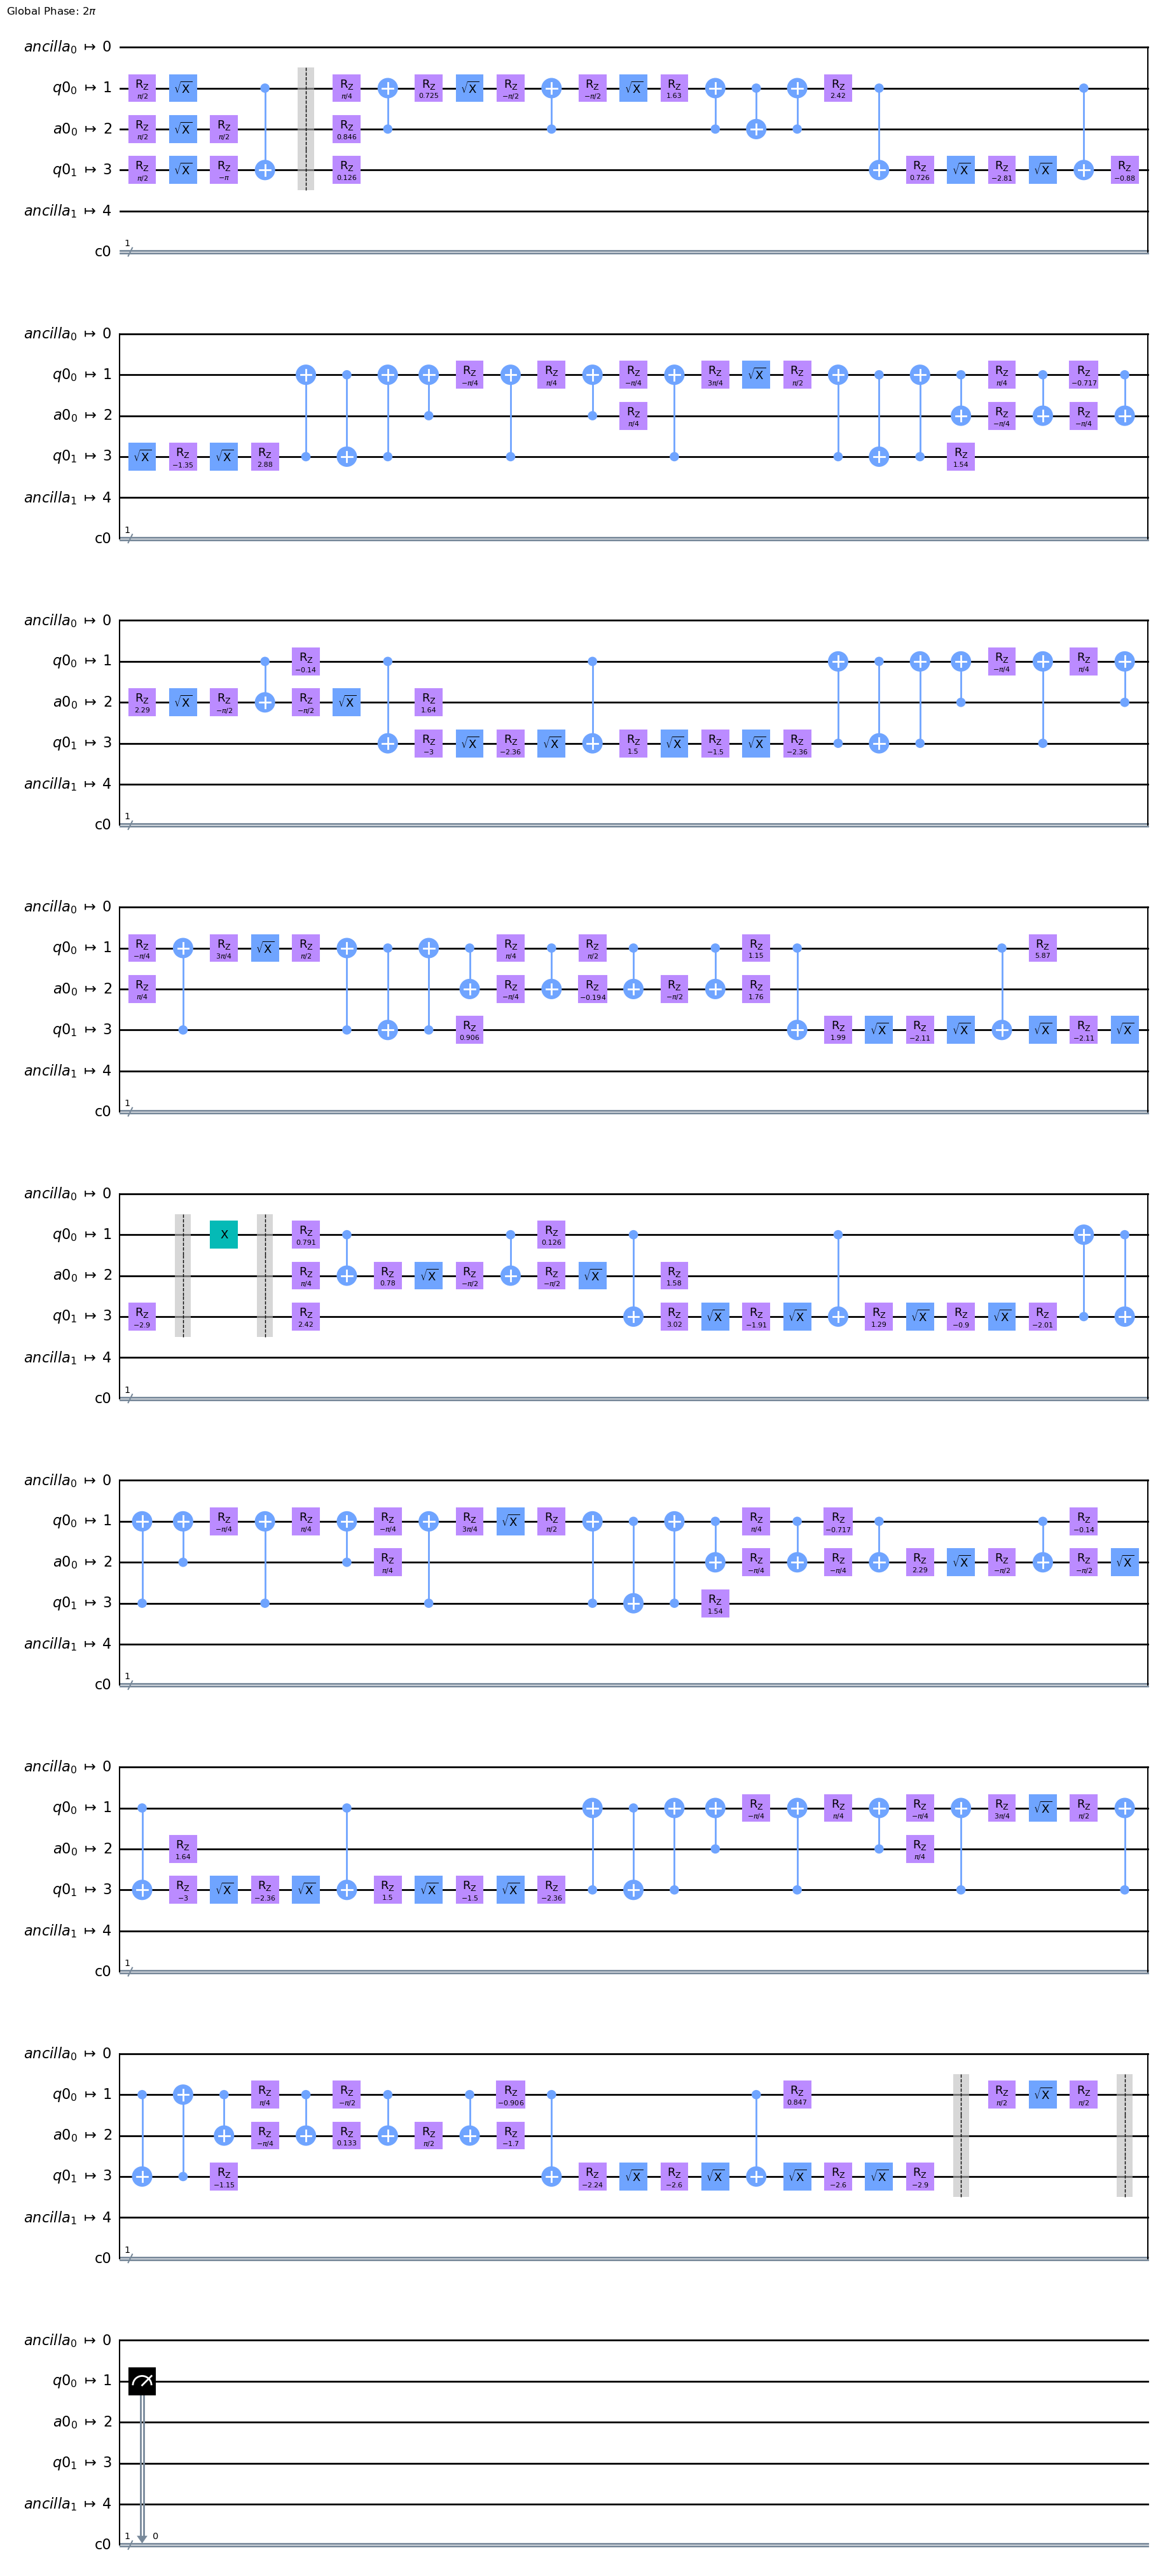

In [21]:
trans_re[1].draw('mpl')

Text(0, 0.5, 'Circuit Depth')

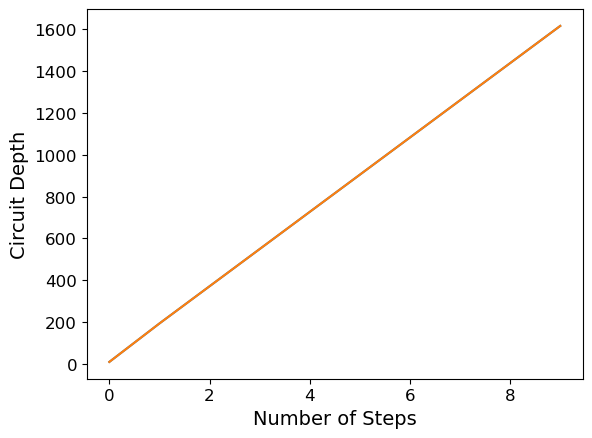

In [22]:
plt.plot(re_depths, label='Real')
plt.plot(im_depths, label='Imag')
plt.xlabel("Number of Steps")
plt.ylabel("Circuit Depth")